In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import simplstyles
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
from voxelwise_tutorials.io import load_hdf5_array

from fmri.features import load_brain_data
from fmri.features import load_feature
from fmri.plotting import plot_flatmap_from_mapper
from fmri.results import get_result_path
from fmri.ridge import run_ridge_pipeline, run_banded_pipeline
from fmri.variance_partitioning import signed_square

In [2]:
plt.style.use('nord-light-talk')
data_dir = "../../data"
backend = set_backend('torch_cuda', on_error='warn')
simplstyles.styles['nord-light-talk']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '#abb9cf',
          'axes.facecolor': 'white',
          'axes.grid': False,
          'axes.labelcolor': '#434c5e',
          'axes.labelsize': 18.0,
          'axes.linewidth': 1.25,
          'axes.prop_cycle': cycler('color', ['#5e81ac', '#88c0d0', '#d08770', '#bf616a', '#b48ead', '#a3be8c', '#ebcb8b', '#abb9cf']),
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titlelocation': 'left',
          'axes.titlesize': 18.0,
          'axes.titleweight': 'bold',
          'boxplot.showbox': False,
          'boxplot.showcaps': False,
          'boxplot.showfliers': False,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Inter',
                              'Helvetica',
                              'Arial',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                   

In [3]:
modality = "reading"
subject = 1
low_level_feature = "letters"
trim = 5  # remove 5 TRs from the start and end of each story
number_of_delays = 4

In [4]:
alphas = np.logspace(-5, 25, 20)
cv = 5
n_iter = 10

In [5]:
n_targets_batch = 100
n_alphas_batch = 5
n_targets_batch_refit = 100

## Load Low Level Feature

In [6]:
X_low_level, n_samples_train = load_feature(data_dir, low_level_feature)
print(X_low_level.shape)

(4193, 26)


## Load High Level (NLP) Features

In [7]:
X_semantic, n_samples_train = load_feature(data_dir, "english1000")
print(X_semantic.shape)

(4193, 985)


# Load Brain Data

In [8]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality)
print(Y.shape)

KeyboardInterrupt: 

# Variance Partitioning

## Low Level Prediction

In [6]:
low_level_file = os.path.join(get_result_path(modality, subject), f"{low_level_feature}_scores.csv")

In [12]:
if not os.path.exists(low_level_file):
    print(f"Saving {low_level_file}")
    vp_low_level_scores = run_ridge_pipeline(X_low_level, Y, n_samples_train, alphas, cv,
                                             number_of_delays, n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    vp_low_level_scores.to_csv(low_level_file)
else:
    print(f"Loading {low_level_file}")
    vp_low_level_scores = pd.read_csv(low_level_file)

# remove nan values
print(vp_low_level_scores.max(), vp_low_level_scores.min(), vp_low_level_scores.mean())
vp_low_level_scores.head()

Loading results/reading/subject01/letters_scores.csv
correlation_score    0.618126
r2_score             0.381840
p_value              0.999963
dtype: float64 correlation_score   -2.852295e-01
r2_score                     -inf
p_value              1.226238e-33
dtype: float64 correlation_score    0.047802
r2_score                 -inf
p_value              0.364139
dtype: float64


correlation_score      r2_score  p_value
0                NaN          -inf      NaN
1                NaN -2.359035e+14      NaN
2                NaN  0.000000e+00      NaN
3                NaN  0.000000e+00      NaN
4                NaN -1.675517e+14      NaN

In [13]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
flatmap_mask = load_hdf5_array(mapper_path, key='flatmap_mask')

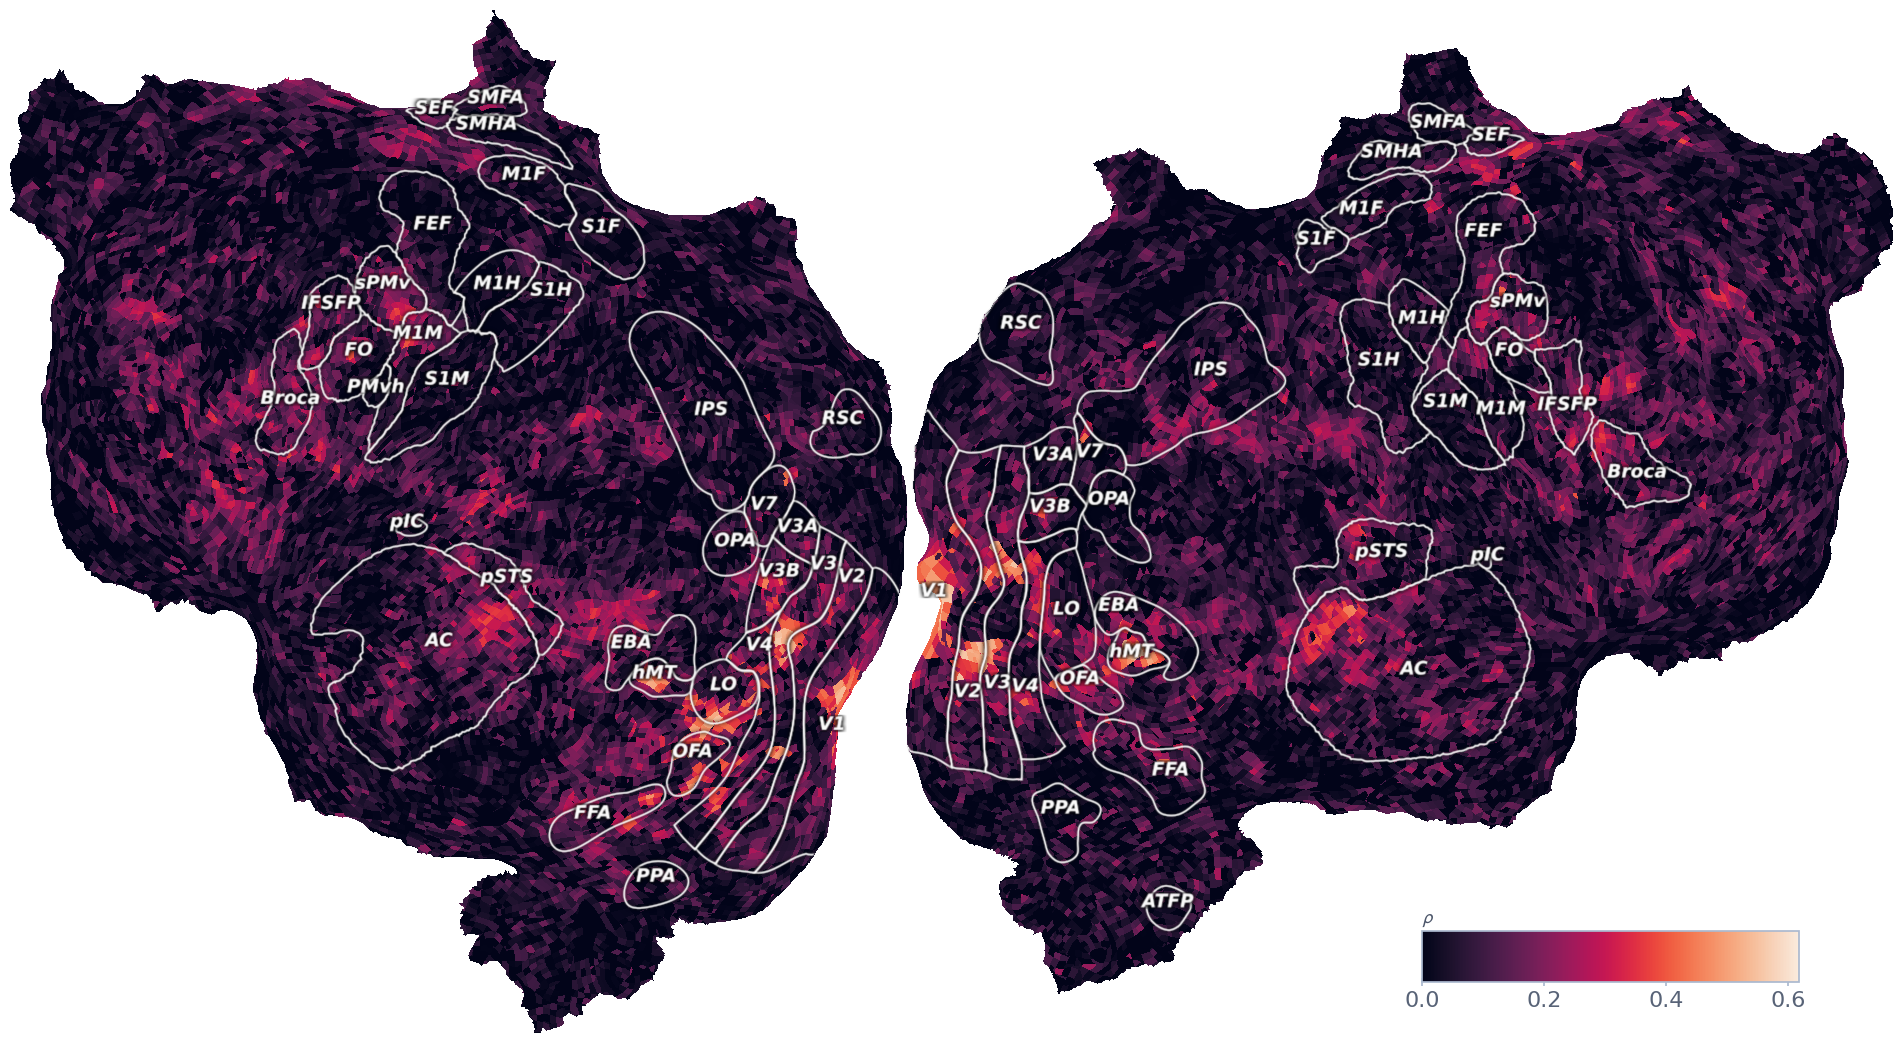

In [14]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_low_level_correlation = vp_low_level_scores['correlation_score']
vp_low_level_correlation = vp_low_level_correlation.to_numpy()
vp_low_level_correlation = np.nan_to_num(vp_low_level_correlation)

plot_flatmap_from_mapper(vp_low_level_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(vp_low_level_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

## Semantic Prediction

In [15]:
semantic_file = os.path.join(get_result_path(modality, subject), f"english1000_scores.csv")

In [18]:
if not os.path.exists(semantic_file):
    print(f"Saving {semantic_file}")
    vp_semantic_scores = run_ridge_pipeline(X_semantic, Y, n_samples_train, alphas, cv, number_of_delays,
                                            n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    vp_semantic_scores.to_csv(semantic_file)
else:
    print(f"Loading {semantic_file}")
    vp_semantic_scores = pd.read_csv(semantic_file)

# remove nan values
print("max\n", vp_semantic_scores.max(), "\nmin\n", vp_semantic_scores.min(), "\nmean\n", vp_semantic_scores.mean())

Loading results/reading/subject01/english1000_scores.csv
max
 correlation_score    0.641038
r2_score             0.409061
p_value              0.999995
dtype: float64 
min
 correlation_score   -2.571359e-01
r2_score                     -inf
p_value              8.254671e-37
dtype: float64 
mean
 correlation_score    0.061908
r2_score                 -inf
p_value              0.332173
dtype: float64


0.6410376707820696


<Axes: >

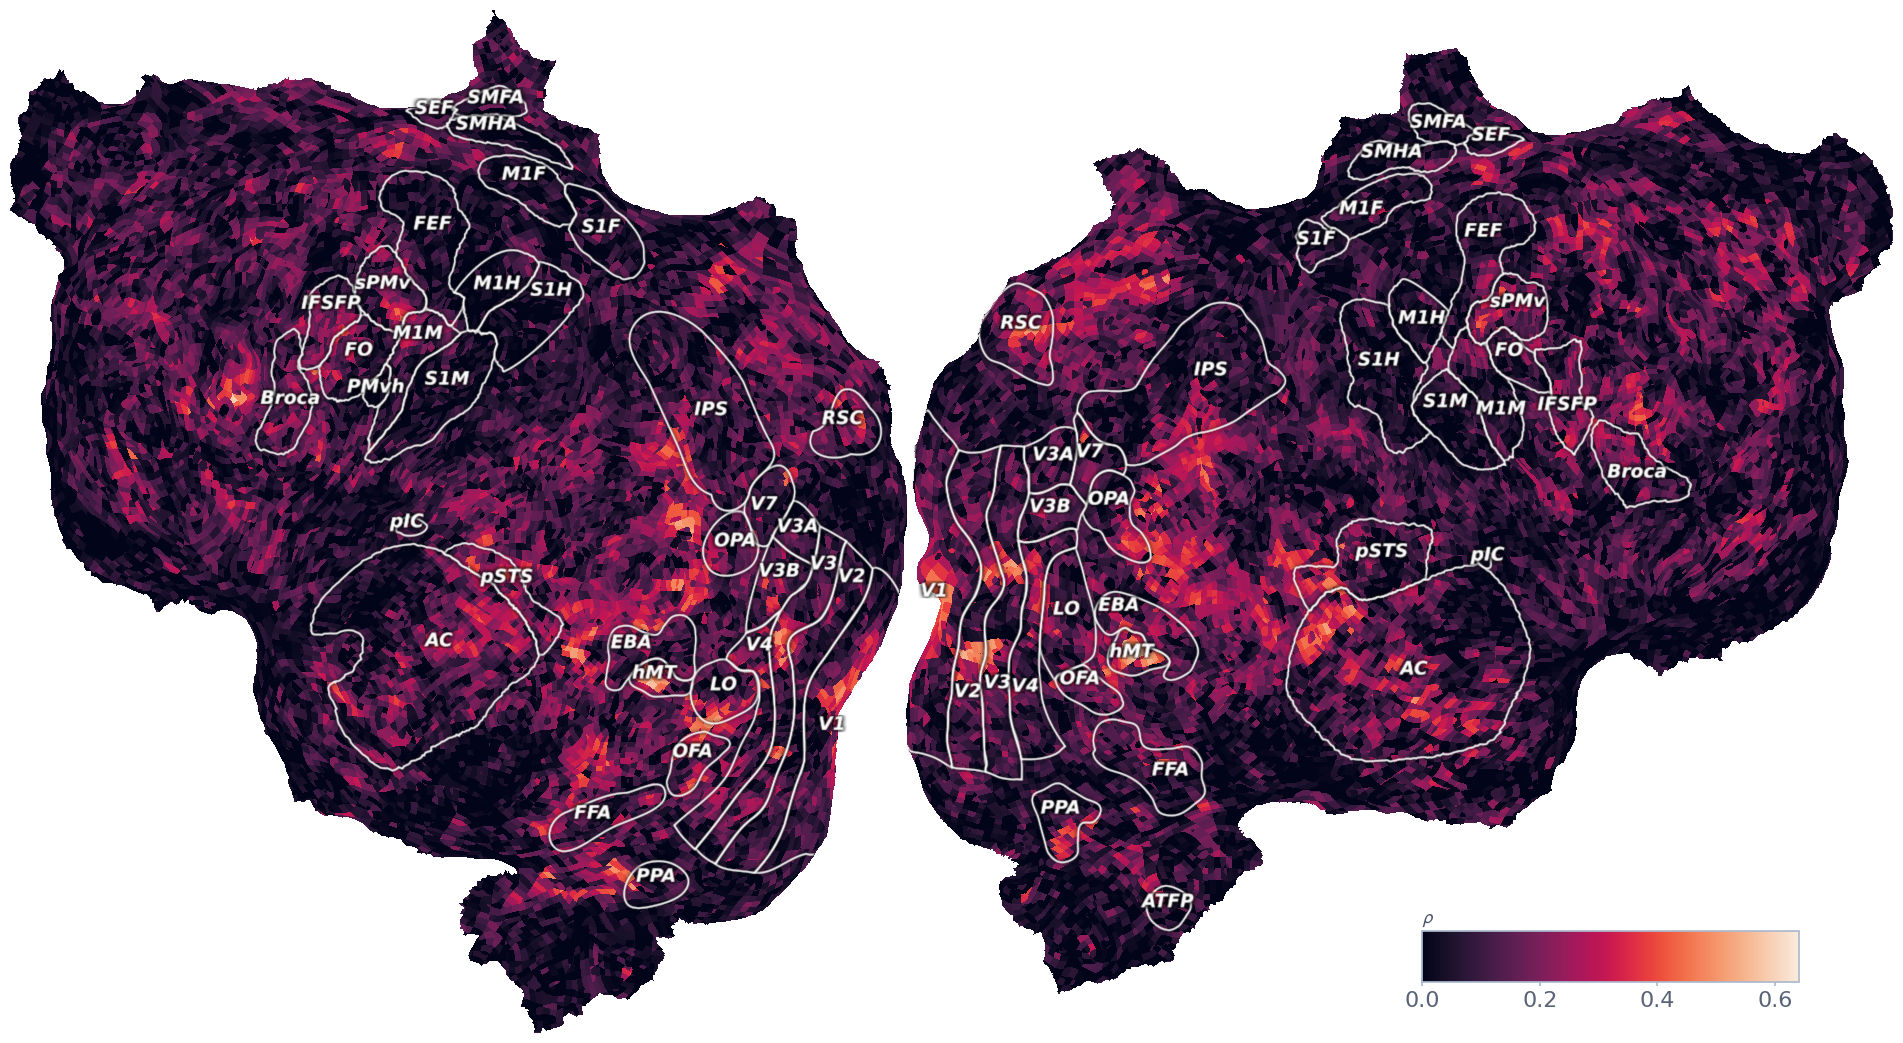

In [19]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_semantic_correlation = vp_semantic_scores['correlation_score']
vp_semantic_correlation = vp_semantic_correlation.to_numpy()
vp_semantic_correlation = np.nan_to_num(vp_semantic_correlation)
vmax = vp_semantic_correlation.max()
print(vmax)

plot_flatmap_from_mapper(vp_semantic_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=vmax, colorbar_location=[0.75, 0.05, 0.2, 0.05])


## Joint Prediction

In [17]:
joint_file = os.path.join(get_result_path(modality, subject), f"joint_english1000_{low_level_feature}_scores.csv")

In [18]:
if not os.path.exists(joint_file):
    print(f"Saving {joint_file}")
    Xs = np.concatenate([X_semantic, X_low_level], axis=1)
    n_features_list = [X_semantic.shape[1], X_low_level.shape[1]]
    vp_joint_scores = run_banded_pipeline(Xs, n_features_list, Y, n_samples_train, alphas, cv, n_iter, number_of_delays,
                                          n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    vp_joint_scores.to_csv(joint_file)
else:
    print(f"Loading {joint_file}")
    vp_joint_scores = pd.read_csv(joint_file, index_col=0)

# remove nan values
print("max\n", vp_joint_scores.max(), "\nmin\n", vp_joint_scores.min(), "\nmean\n", vp_joint_scores.mean())

Saving results/reading/subject01/joint_english1000_letters_scores.csv
(3887, 1011) (3887, 81133)


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 10 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 818.32 sec | 10 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


max
 correlation_score    0.546927
r2_score             0.290874
p_value              0.999973
dtype: float64 
min
 correlation_score   -1.917086e-01
r2_score            -2.310252e+14
p_value              4.888749e-49
dtype: float64 
mean
 correlation_score    5.177794e-02
r2_score            -2.041798e+10
p_value              3.150753e-01
dtype: float64


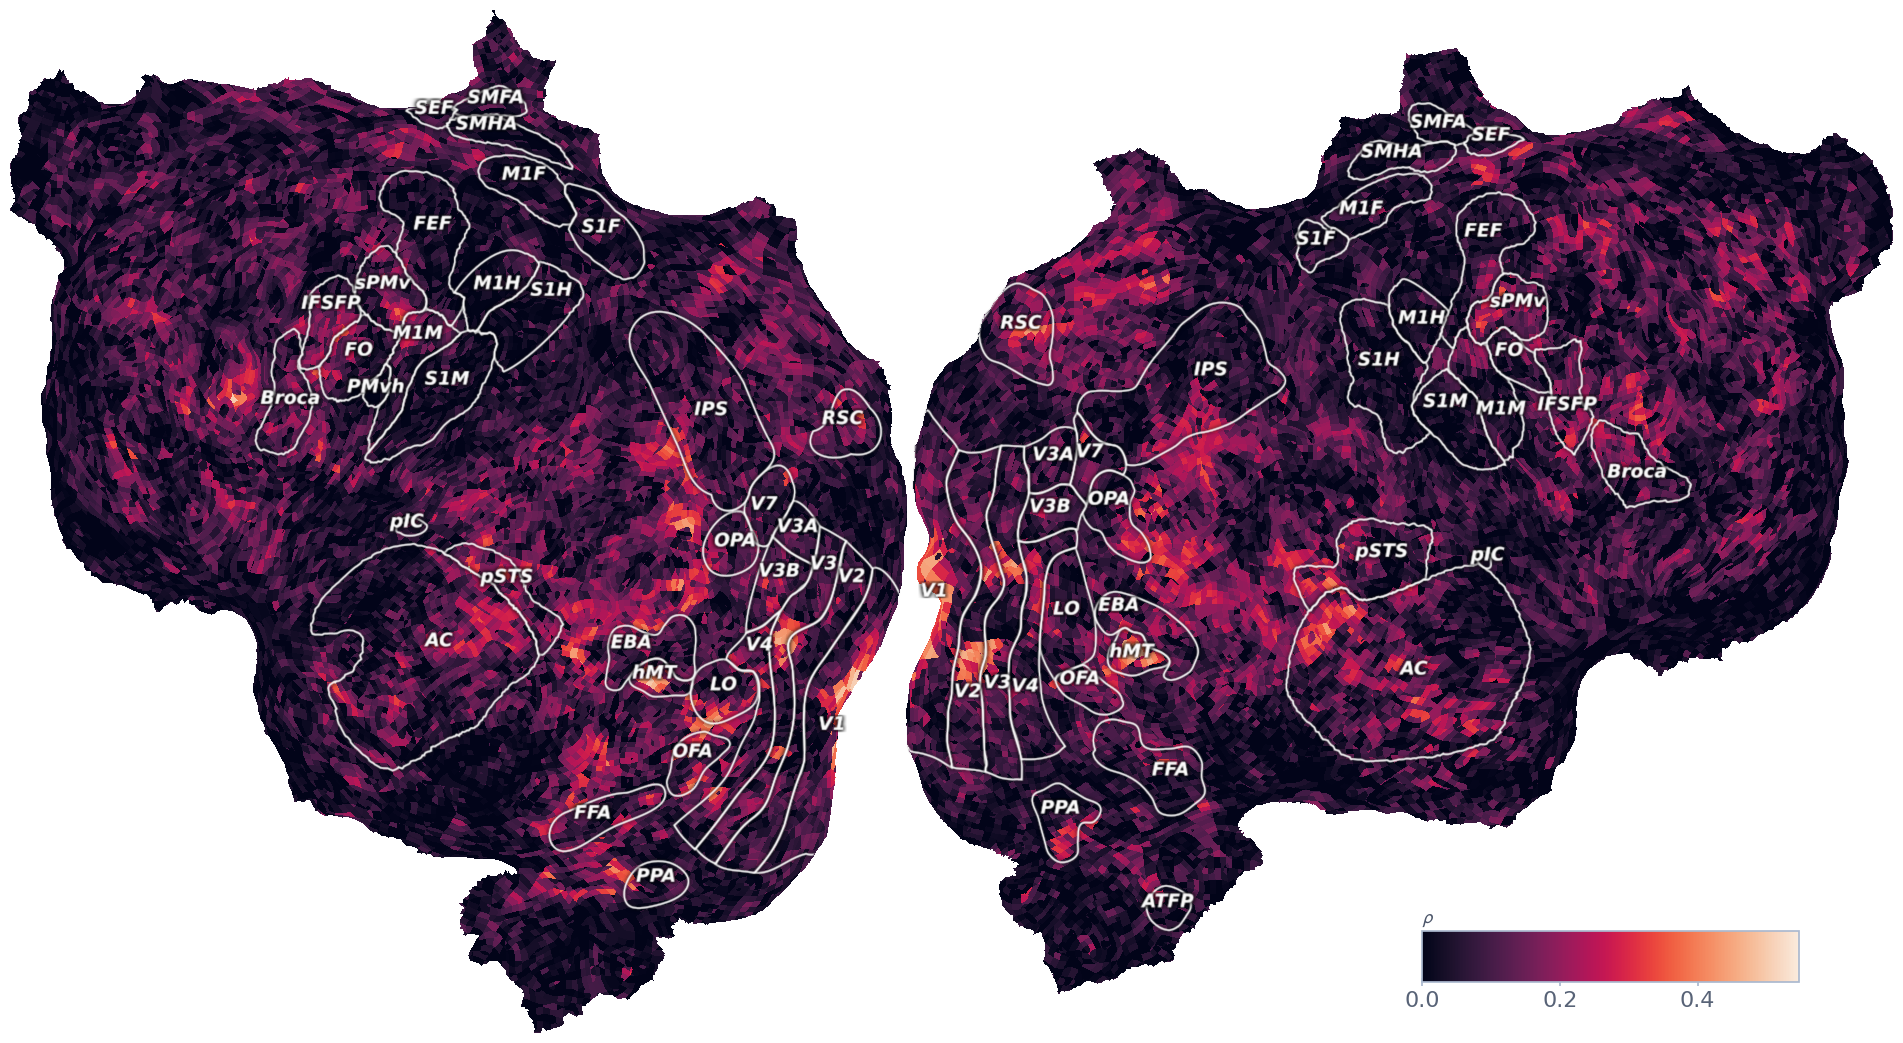

In [19]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_joint_correlation = vp_joint_scores['correlation_score']
vp_joint_correlation = vp_joint_correlation.to_numpy()
vp_joint_correlation = np.nan_to_num(vp_joint_correlation)

plot_flatmap_from_mapper(vp_joint_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(vp_joint_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

## Perform Variance Partitioning

In [30]:
intersection = signed_square(vp_joint_scores['correlation_score']) + signed_square(
    vp_low_level_scores['correlation_score']) - signed_square(vp_semantic_scores['correlation_score'])
semantic_minus_low_level = signed_square(vp_semantic_scores['correlation_score']) - intersection
semantic_minus_low_level = np.sqrt(semantic_minus_low_level)
semantic_minus_low_level = np.nan_to_num(semantic_minus_low_level)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


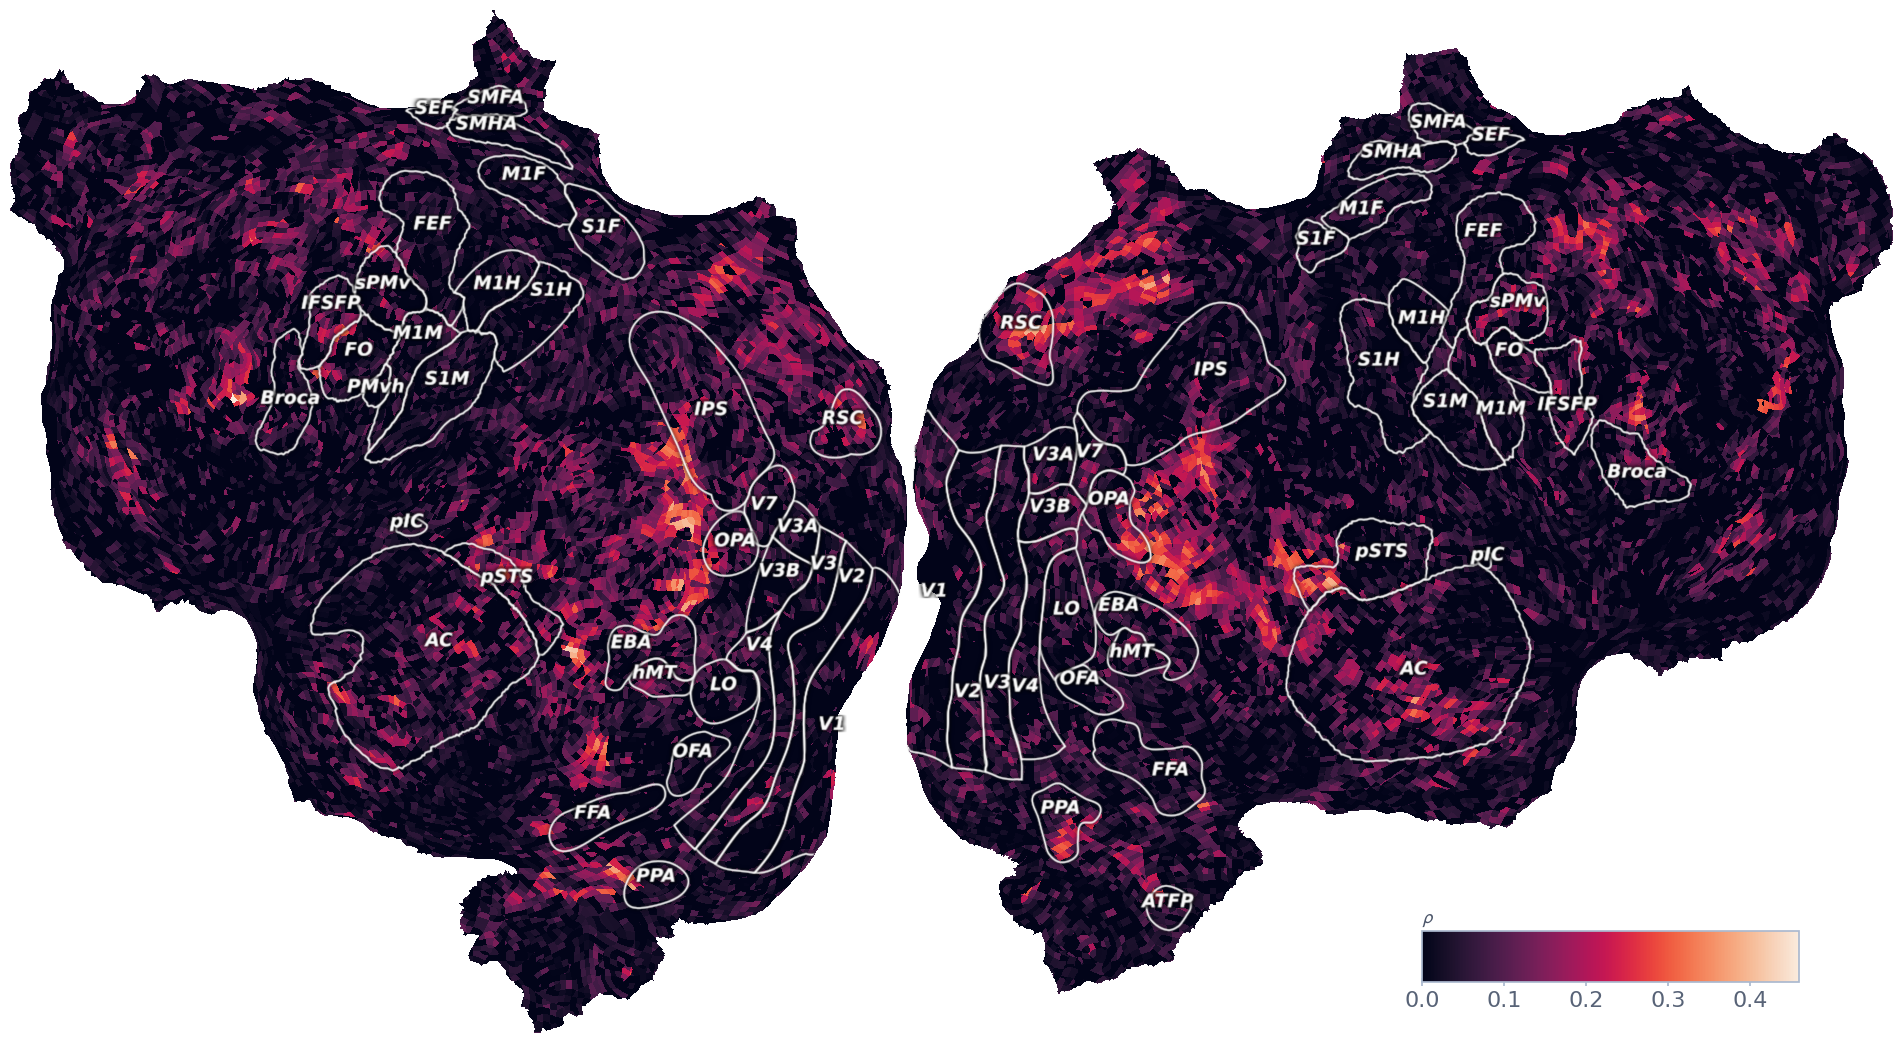

In [31]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

plot_flatmap_from_mapper(semantic_minus_low_level, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(semantic_minus_low_level), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

# Residual Method

## Cross-feature Prediction

In [32]:
from himalaya.ridge import Ridge

solver_params = dict(n_targets_batch=n_targets_batch)
cross_model = Ridge(alpha=1, solver_params=solver_params)
cross_model.fit(X_low_level[:n_samples_train], X_semantic[:n_samples_train])

Ridge(solver_params={'n_targets_batch': 100})

In [33]:
cross_path = os.path.join(get_result_path(modality, subject), f"cross_{low_level_feature}_english1000_scores.csv")

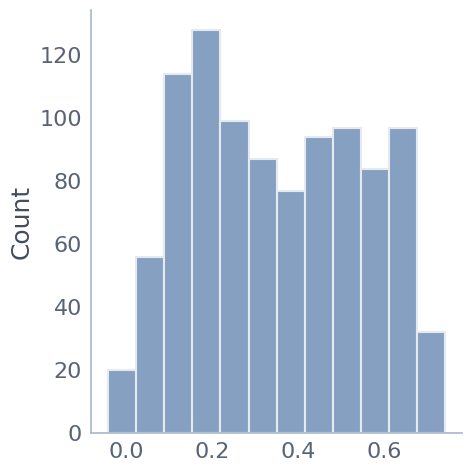

In [34]:
r2_scores = cross_model.score(X_low_level[n_samples_train:], X_semantic[n_samples_train:])
r2_scores = backend.to_numpy(r2_scores)
sns.displot(r2_scores)
r2_scores = pd.DataFrame(r2_scores, columns=['r2_cross'])
r2_scores.to_csv(cross_path, index=False)

## Create Residuals

In [35]:
semantic_pred = cross_model.predict(X_low_level)
semantic_pred = backend.to_numpy(semantic_pred)

In [36]:
X_semantic_residual = X_semantic - semantic_pred

## Train on Residuals

In [37]:
residual_file = os.path.join(get_result_path(modality, subject), f"residual_english1000_{low_level_feature}_scores.csv")

In [38]:
if not os.path.exists(residual_file):
    print(f"Saving {residual_file}")
    residual_scores = run_ridge_pipeline(X_semantic_residual, Y, n_samples_train, alphas, cv, number_of_delays,
                                         n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    residual_scores.to_csv(residual_file)
else:
    print(f"Loading {residual_file}")
    residual_scores = pd.read_csv(residual_file, index_col=0)

print("max\n", residual_scores.max(), "\nmin\n", residual_scores.min(), "\nmean\n", residual_scores.mean())

Loading results/reading/subject01/residual_english1000_letters_scores.csv
max
 correlation_score    0.474579
r2_score             0.209082
p_value              0.999999
dtype: float64 
min
 correlation_score   -1.911698e-01
r2_score            -2.310252e+14
p_value              1.068800e-35
dtype: float64 
mean
 correlation_score    2.814524e-02
r2_score            -2.041785e+10
p_value              3.890218e-01
dtype: float64


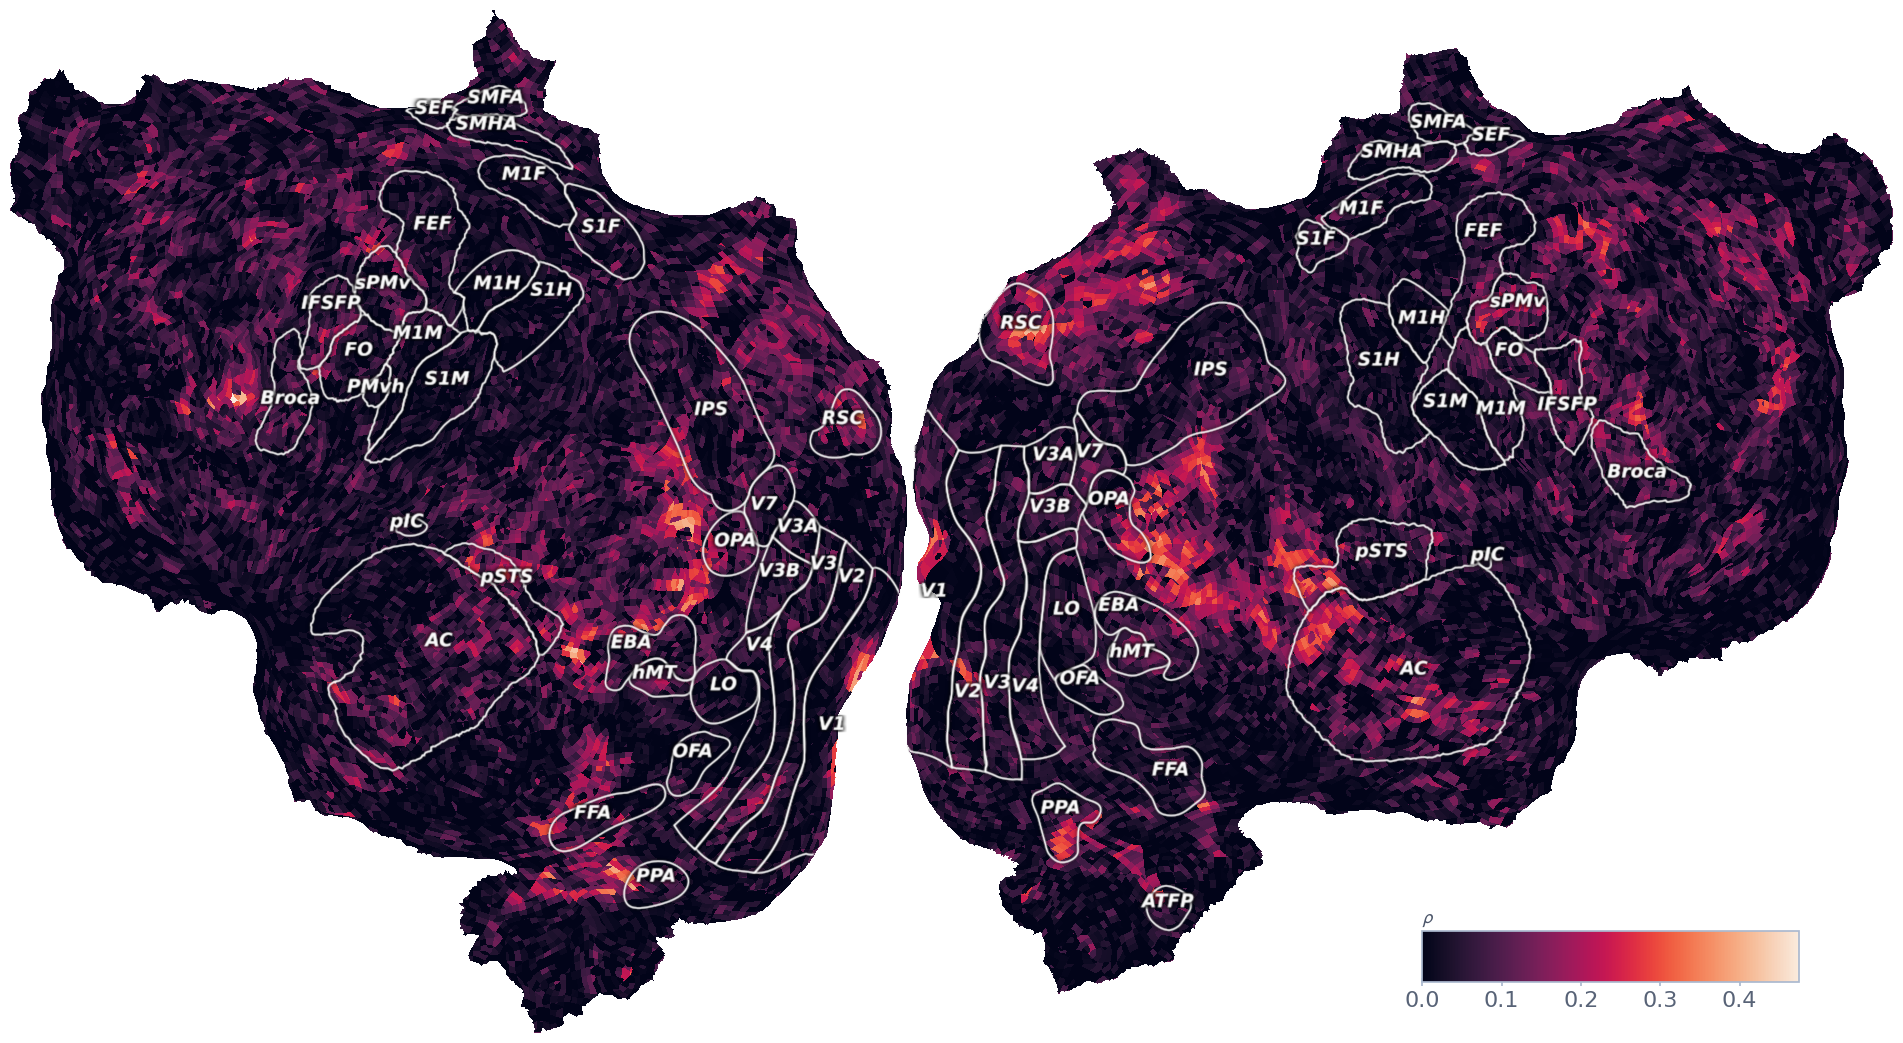

In [39]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

residual_correlation = residual_scores['correlation_score']
residual_correlation = residual_correlation.to_numpy()
residual_correlation = np.nan_to_num(residual_correlation)

plot_flatmap_from_mapper(residual_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(residual_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()